In [1]:
import ctypes
import numpy as np

from picosdk.ps4000a import ps4000a as ps
from picosdk.functions import adc2mV, assert_pico_ok

import time

In [2]:
# Create chandle and status ready for use
chandle = ctypes.c_int16()
status = {}

# Open 4000 series PicoScope
# Returns handle to chandle for use in future API functions
status["openunit"] = ps.ps4000aOpenUnit(ctypes.byref(chandle), None)
assert_pico_ok(status["openunit"])
#test

In [3]:
enabled = 1
disabled = 0
analogue_offset = 0.0
channel_range = 7
status["setChA"] = ps.ps4000aSetChannel(chandle,
                                        ps.PS4000A_CHANNEL['PS4000A_CHANNEL_A'],
                                        enabled,
                                        ps.PS4000A_COUPLING['PS4000A_DC'],
                                        channel_range,
                                        analogue_offset)
assert_pico_ok(status["setChA"])

In [4]:
sizeOfOneBuffer = 1000

# Create buffers ready for assigning pointers for data collection
bufferAMax = np.zeros(shape=sizeOfOneBuffer, dtype=np.int16)

memory_segment = 0

status["setDataBuffersA"] = ps.ps4000aSetDataBuffers(chandle,
                                                     ps.PS4000A_CHANNEL['PS4000A_CHANNEL_A'],
                                                     bufferAMax.ctypes.data_as(ctypes.POINTER(ctypes.c_int16)),
                                                     None,
                                                     sizeOfOneBuffer,
                                                     memory_segment,
                                                     ps.PS4000A_RATIO_MODE['PS4000A_RATIO_MODE_NONE'])
assert_pico_ok(status["setDataBuffersA"])

In [5]:

numBuffersToCapture = 10
totalSamples = sizeOfOneBuffer * numBuffersToCapture

#Begin streaming
sampleInterval = ctypes.c_int32(1000)
sampleUnits = ps.PS4000A_TIME_UNITS['PS4000A_US']
# We are not triggering:
maxPreTriggerSamples = 0
autoStopOn = 1
# No downsampling:
downsampleRatio = 1
status["runStreaming"] = ps.ps4000aRunStreaming(chandle,
                                                ctypes.byref(sampleInterval),
                                                sampleUnits,
                                                maxPreTriggerSamples,
                                                totalSamples,
                                                autoStopOn,
                                                downsampleRatio,
                                                ps.PS4000A_RATIO_MODE['PS4000A_RATIO_MODE_NONE'],
                                                sizeOfOneBuffer)
assert_pico_ok(status["runStreaming"])

In [6]:
bufferCompleteA = np.zeros(shape=totalSamples, dtype=np.int16)
global nextSample, autoStopOuter, wasCalledBack
nextSample = 0
autoStopOuter = False
wasCalledBack = False
#global wasCalledBack, nextSample, autoStopOuter

def streaming_callback(handle, noOfSamples, startIndex, overflow, triggerAt, triggered, autoStop, param):
    global wasCalledBack, nextSample, autoStopOuter
    wasCalledBack = True
    destEnd = nextSample + noOfSamples
    sourceEnd = startIndex + noOfSamples
    bufferCompleteA[nextSample:destEnd] = bufferAMax[startIndex:sourceEnd]
    nextSample += noOfSamples
    if autoStop:
        autoStopOuter = True

# Convert the python function into a C function pointer.
cFuncPtr = ps.StreamingReadyType(streaming_callback)

In [7]:
nextSample = 0
autoStopOuter = False
status["runStreaming"] = ps.ps4000aRunStreaming(chandle,
                                                ctypes.byref(sampleInterval),
                                                sampleUnits,
                                                maxPreTriggerSamples,
                                                totalSamples,
                                                autoStopOn,
                                                downsampleRatio,
                                                ps.PS4000A_RATIO_MODE['PS4000A_RATIO_MODE_NONE'],
                                                sizeOfOneBuffer)
assert_pico_ok(status["runStreaming"])
while nextSample < totalSamples and not autoStopOuter:
        wasCalledBack = False
        status["getStreamingLastestValues"] = ps.ps4000aGetStreamingLatestValues(chandle, cFuncPtr, None)
        if not wasCalledBack:
            # If we weren't called back by the driver, this means no data is ready. Sleep for a short while before trying
            # again.
            time.sleep(0.01)

In [25]:
status["stop"] = ps.ps4000aStop(chandle)
assert_pico_ok(status["stop"])
status["close"] = ps.ps4000aCloseUnit(chandle)
assert_pico_ok(status["close"])

PicoSDKCtypesError: PicoSDK returned 'PICO_INVALID_HANDLE'

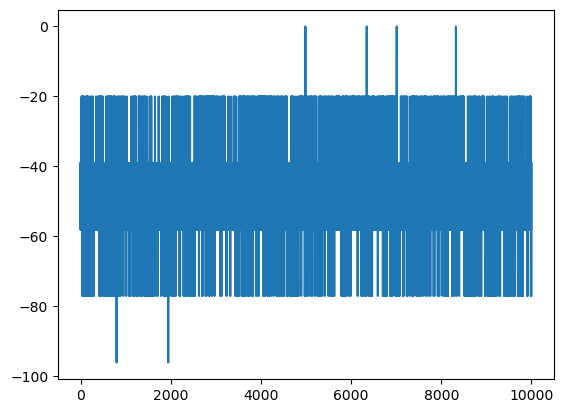

In [8]:
import matplotlib.pyplot as plt

plt.plot(bufferCompleteA)

In [3]:
import h5py
import numpy as np

In [9]:
filename = "C:/Users/yalem/OneDrive/Documents/Picoscope Tests/Pico Control/test.hdf5"
with h5py.File(filename, 'w') as f:
    f['dataset'] = np.linspace(0, 100, 101)


In [10]:
with h5py.File(filename, 'r') as f:
    print(np.array(f['dataset']))

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100.]
